In [38]:
# Importing dependencies
import pandas as pd
import os
import numpy as np
from datetime import datetime
from typing import List, Union, Iterator, Tuple, Any
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from functools import partial
from sklearn.model_selection import train_test_split

# Filter and ignore some tf warnings
# skip debug and warning logs
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#import keras.api._v2.keras as keras # this is the exact package tensorflow loads
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input, Activation, Flatten, Lambda, Resizing, MaxPooling2D,  Conv2D, Concatenate, UpSampling2D, Cropping2D
from keras.models import Sequential, Model, load_model
from keras.applications import mobilenet_v2, mobilenet_v3, vgg16, xception, resnet, EfficientNetV2B3, EfficientNetV2S
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, History, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam, SGD
from keras.losses import mean_squared_error
import keras_tuner as kt
from keras import backend

# Enable lazy CUDA initialization
os.environ['CUDA_MODEL_LOADING'] = 'LAZY'

In [2]:
# Limit GPU memory growth prior to allocating any tensors
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

2023-04-25 00:55:15.985266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-25 00:55:16.074059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-25 00:55:16.074114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


In [54]:
# global variables
IMG_HEIGHT = 224 # image height
IMG_WIDTH = 224 # image width
CHANNELS = 3 # choose 1 if you're working with grayscale images else 3
BATCH_SIZE = 64 # number of images to process in one batch
epochs = 100 # number of epochs
step_size = 150 # number of steps per epoch
val_step_size = 80 # number of steps per epoch for validation data
data_path='./machine-learning-in-science-ii-2023' # parent path to training and testing data

In [4]:
def load_data(data_path: str) -> pd.DataFrame:
    """Loads data from csv file
    Params
    ------
    data_path: str
        Data path containing images and csv data
    Returns
    -------
    pd.DataFrame
        Loaded data as pandas dataframe
    """
    columns = ['image_id', 'angle', 'speed']
    data = pd.read_csv(os.path.join(data_path, 'training_norm.csv'), delimiter= ',', header=0, names = columns)

    return data

In [5]:
# Appends absolute path with image id column
def append_path(data: pd.DataFrame, data_path: os.PathLike) -> pd.DataFrame:
  data['image_id'] = data.image_id.apply(lambda x: os.path.join(data_path, 'training_data/', str(x)) + '.png')
  return data

## Data preprocessing

In [6]:
# train test split of dataset
def split_data(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Params
    ------
    data: pd.DataFrame
        Pandas dataframe containing all data.
    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame]
        A tuple of train and val split
    """
    rnd = np.random.RandomState(seed=None)

    train_data, val_data = train_test_split(data, test_size=0.2, random_state=rnd.seed(1234)) # split data with test size of 20%
    #test_data, val_data = train_test_split(train_data, test_size=0.12, random_state=rnd.seed(1234)) # split validation data with test size of 12.5%
    return train_data, val_data

In [7]:
data = load_data(data_path)

In [8]:
data.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [9]:
data = append_path(data, data_path)

In [10]:
# image_id should contain complete path for images 
data['image_id'].tolist()[1]

'./machine-learning-in-science-ii-2023/training_data/2.png'

In [11]:
data.to_csv('./new_training_data.csv', sep=',')

In [12]:
# splitting data into training and validation set
train_data, val_data = split_data(data)

In [13]:
# plotting distribution of output labels
def visualize(data):
    plt.hist(data.loc[:,'angle'])
    plt.hist(data.loc[:,'speed'])
    plt.legend(['Steering angle', 'Driving speed'])
    plt.title('Distribution plot for steering angle and speed')
    plt.grid(False)
    plt.show()

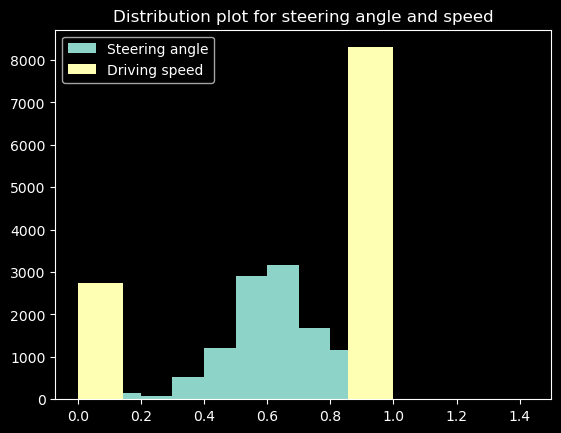

In [14]:
# Plotting train_data
visualize(data=train_data)

## Data pipeline

In [15]:
def modify_rgb(img, height: int = 224, width: int= 224, color_mode: str='rgb'):
    img = tf.image.resize(img, size=(height, width)) # resize image to given height and width
    img = tf.cast(img, tf.float32) # convert image to float32
    # normalize pixel values
    img = tf.divide(img, 255.0)
    img = tf.multiply(img, 2)
    img = tf.subtract(img, 1)
    if color_mode == 'yuv':
        img = tf.image.rgb_to_yuv(img) # convert image to YUV
    elif color_mode == 'grayscale':
        img = tf.image.rgb_to_grayscale(img) # convert to Grayscale
    elif color_mode == 'hsv':
        img = tf.image.rgb_to_hsv(img) # convert image to YUV
    # return modified image
    return img

In [16]:
# Generate images on the fly while training model
def img_generator(train_data: pd.DataFrame, test_dir: os.PathLike, val_data: pd.DataFrame, BATCH_SIZE: int, IMG_HEIGHT: int, IMG_WIDTH: int, color_mode: str='rgb') -> Tuple[Iterator, Iterator, Iterator]:
    """
    Params
    ------
    train_data: pd.DataFrame
        Pandas dataframe containing training data
    test_dir: os.PathLike
        Path containing testing data
    val_data: pd.DataFrame
        Pandas dataframe containing validation data
    BATCH_SIZE: int
        Number of images to process in each batch
    IMG_HEIGHT: int
        image height
    IMG_WIDTH: int
        image width

    Returns
    -------
    Tuple[Iterator, Iterator, Iterator]
        keras ImageDataGenerators used for training and validating model.
    """
    # Define partial function to pass image height and width to preprocessing function
    preprocess_input = partial(modify_rgb, height=IMG_HEIGHT, width=IMG_WIDTH, color_mode=color_mode)
    # Define a dictionary of arguments for the data generators
    datagen_args = dict(
        #rescale=(1.0 / 255), # normalize pixels in range 0 and 1
        rotation_range=20,
        shear_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        zoom_range=(0.75, 1),
        fill_mode='nearest',
        samplewise_center=False,
        horizontal_flip=True,
        vertical_flip=False
        )

    # Define data generators with datagen arguments
    train_generator = ImageDataGenerator(**datagen_args, preprocessing_function=preprocess_input)
    test_generator = ImageDataGenerator(**datagen_args, preprocessing_function=preprocess_input)
    val_generator = ImageDataGenerator(**datagen_args, preprocessing_function=preprocess_input)


    train_generator = train_generator.flow_from_dataframe(dataframe=train_data,
                                                          directory=None,
                                                          x_col='image_id',
                                                          y_col=['angle','speed'],
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          color_mode='rgb',
                                                          class_mode='raw',
                                                          batch_size=BATCH_SIZE,
                                                          seed=tf.random.set_seed(1234),
                                                          shuffle=True)

    test_generator = test_generator.flow_from_directory(directory=test_dir,
                                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                        color_mode='rgb',
                                                        class_mode=None,
                                                        classes=None,
                                                        batch_size=1, # Process whole batch at once
                                                        seed=tf.random.set_seed(1234),
                                                        shuffle=False)

    val_generator = val_generator.flow_from_dataframe(dataframe=val_data,
                                                      directory=None,
                                                      x_col='image_id',
                                                      y_col=['angle', 'speed'],
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      color_mode='rgb',
                                                      class_mode='raw',
                                                      batch_size=BATCH_SIZE,
                                                      seed=tf.random.set_seed(1234),
                                                      shuffle=True)
                                                      #save_to_dir='machine-learning-in-science-ii-2023/augmentations', save_format='png')

    return train_generator, test_generator, val_generator


In [55]:
# create data generators for train test and val data
#training_ds, testing_ds, validation_ds = create_img_pipeline(train_ds, test_ds, val_ds)
test_dir = os.path.join(data_path, 'test_data')

train_generator, test_generator, val_generator = img_generator(train_data, test_dir, val_data, BATCH_SIZE=BATCH_SIZE, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, color_mode='rgb')

Found 11034 validated image filenames.
Found 1020 images belonging to 1 classes.
Found 2759 validated image filenames.


## Define keras Callbacks

In [18]:
class TestMSECallback(Callback):
    def __init__(self, test_generator):
        super().__init__()
        self.test_generator = test_generator

    def on_epoch_end(self, epoch, logs={}):
        y_true = self.test_generator.labels
        y_pred = self.model.predict(self.test_generator)
        mse = mean_squared_error(y_true, y_pred).numpy()
        logs['test_mse'] = float(mse)
        print(f'MSE on test data at the end of epoch {epoch+1}: {float(mse):.5f}')

In [19]:
# Define a function to adjust learning rate if val_loss has seen no improvements after 5 epochs
class CustomLearningRateScheduler(Callback):
    """Custom Learning rate scheduler which sets learning rate according to a schedule"""
    def __init__(self, factor=0.1, patience=5, verbose=0):
        super(CustomLearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.verbose = verbose if verbose is not None else 0
        self.best_val_loss = float('inf')
        self.wait = 0
        self.new_lr = None # Initialize new_lr to None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')

        if val_loss < self.best_val_loss: # if current val_loss is less than best_val_loss
            self.best_val_loss = val_loss # update new best_val_loss
            self.wait = 0
        else:
            self.wait += 1 # Start wait timer
            if self.wait >= self.patience and self.new_lr is None:
                old_lr = float(backend.get_value(self.model.optimizer.learning_rate))
                self.new_lr = old_lr * self.factor
            if self.verbose == 1:
                print(f'\nEpoch {epoch}: Reducing learning rate to {self.new_lr:.6f}')
            backend.set_value(self.model.optimizer.learning_rate, self.new_lr)
            self.wait = 0

In [20]:
# Custom callback to end training when loss is NaN
class TerminateOnNaN(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        if loss is not None and np.isnan(loss):
            print('Training loss is NaN. Stopping training.')
            self.model.stop_training = True

In [21]:
# defining callbacks
def get_callbacks(model: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint, LearningRateScheduler]]:
    """Accepts the model name as a string and returns multiple keras callbacks

    Params
    ------
    model: str
        The name of model as a string

    Returns
    -------
    A list of multiple keras callbacks
    """
    logdir = (
        'logs/scalars/' + model + '_' + datetime.now().strftime('%Y%m%d-%H%M%S')
    ) # logging for each model
    tensorboard_callback = TensorBoard(log_dir=logdir)

    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,  # model should improve by at least 0.1
        patience=10,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=1,
        baseline=0.009,
        mode='min',
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )

    model_checkpoint_callback = ModelCheckpoint(
        './data/models/' + model + '.h5',
        monitor='val_loss',
        verbose=0,
        save_best_only=True,  # save the best model
        mode='min',
        save_freq='epoch',  # save the model on disk at end of every epoch
    )

    #lr_callback = LearningRateScheduler(schedule_decay)
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.1,
                                    patience=2,
                                    cooldown=5,
                                    verbose=1,
                                    mode='min',
                                    min_delta=0.0001,
                                    min_lr=1e-9
    )
    #custom_lr_callback = CustomLearningRateScheduler()
    term_on_nan_callback = TerminateOnNaN()

    return [tensorboard_callback, early_stopping_callback, model_checkpoint_callback, reduce_lr_callback, term_on_nan_callback]

In [22]:
def conv_block(input, filters, kernel_size, strides: Any=(1,1), padding: str='same', activation: str='relu'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(input)
    x = Activation(activation)(x)
    #x = MaxPooling2D((2, 2), padding='same')(x)
    return x

In [23]:
# Custom activation function
@tf.function
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

In [24]:
# Reference to original paper: https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
def create_nvidia_model(input_shape, dropout_rate, optimizer) -> Model:
    """Creates cnn model based on architecture proposed by NVIDIA
    Parmas
    -------
    input_shape: Any
    dropout_rate: float
    optimizer: keras.optimizers

    Returns
    -------
    """
    # Define kernel_initializers
    glorot_init = tf.keras.initializers.GlorotNormal(seed=42)
    he_init = tf.keras.initializers.HeNormal(seed=42)

    # Define model
    model = Sequential(name='nvidia_model')
    # Cropping input image from 240x320 to 370x110
    model.add(Cropping2D(cropping=((0, 130), (85, 5)), input_shape=input_shape))

    # Resizing cropped image from 370x110 to 250x70
    model.add(Lambda(lambda x: tf.image.resize(x, size=[70, 250])))

    # Convolution blocks
    model.add(Conv2D(36, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer=he_init, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='valid'))

    model.add(Conv2D(48, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer=he_init))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='valid'))

    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer=he_init))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=he_init))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=he_init))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1000, activation='relu', kernel_initializer=he_init))
    #model.add(Dropout(dropout_rate))
    model.add(Dense(100, activation='relu', kernel_initializer=he_init))
    #model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='sigmoid', kernel_initializer=glorot_init))

    # Compile model
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mse', 'accuracy'])

    return model

In [25]:
# Autoencoder implementation
def create_autoencoder_model(input_shape, dropout_rate, optimizer) -> Model:
    """Creates an autoencoder model
    Params
    ------
    input_shape: input dimensions of image (224x224x3).
    dropout_rate: Applies Dropout to the input, to prevent over-fitting.
    optimizer: Optimization algorithm.

    Returns
    -------
    Sequential
        The keras model.
    """
    # Define model

    inputs = Input(shape=input_shape, name='input_layer')

    num_angle_classes = 100
    num_speed_classes = 2

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(inputs)
    x = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2), padding='same')(x)

    conv2 = Conv2D(16, (3, 3),  activation='relu', padding='same', name='conv2')(pool1)
    x = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2), padding='same')(x)

    conv3 = Conv2D(8, (3, 3),  activation='relu', padding='same', name='conv3')(pool2)
    x = BatchNormalization()(conv3)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    deconv1 = Conv2D(8, (3, 3), activation='relu', padding='same', name='deconv1')(encoded)
    x = BatchNormalization()(deconv1)
    up1 = UpSampling2D((2, 2))(x)

    deconv2 = Conv2D(16, (3, 3), strides=(1, 1), activation='relu', padding='same', name='deconv2')(up1)
    x = BatchNormalization()(deconv2)
    up2 = UpSampling2D((2, 2))(x)

    deconv3 = Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', name='deconv3')(up2)
    x = BatchNormalization()(deconv3)
    up3 = UpSampling2D((2, 2))(x)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='decoded')(up3)
    #decoded = GlobalAveragePooling2D(name='decoded')(decoded)

    # Define autoencoder
    autoencoder = Model(inputs, decoded)
    # Compile autoencoder
    autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics='accuracy')

    # Define encoder model to use for predictions
    # add dense layers on top of endoded layer
    flat = Flatten()(encoded)
    fc1 = Dense(128, activation='relu')(flat)
    fc2 = Dense(64, activation='relu')(fc1)
    y = Dropout(dropout_rate)(fc2)
    y = BatchNormalization()(y)

    # Define output layers
    angle_output = Dense(num_angle_classes, name='angle_output', activation='softmax')(y)
    speed_output = Dense(num_speed_classes, name='speed_output', activation='softmax')(y)
    concatenated = Concatenate()([angle_output, speed_output])
    outputs = Dense(2, activation='linear')(concatenated)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss=['mean_squared_error'],
                  optimizer=optimizer,
                  metrics=['mse', 'accuracy'])
    return model

In [26]:
# Creates hybrid model by combining steering_net and speed_net
def create_hybrid_model(input_shape, dropout_rate, optimizer) -> Model:
    """Creates a hybrid model to make two separate predictions on steering angle and speed.

    Params
    ------
    input_shape: input dimensions of images
    dropout_rate: Applies Dropout to the input, to prevent over-fitting.
    optimizer: Optimization algorithm.

    Returns
    -------
    Sequential
        The keras model.
    """
    # Define kernel_initializers for Dense layers
    glorot_init = tf.keras.initializers.GlorotNormal(seed=42)
    he_init = tf.keras.initializers.HeNormal(seed=42)

    # Define input
    inputs = Input(
        shape=input_shape
    )
    ## Define steering_net ##
    #########################
    steering_net = Sequential([
        # Preprocessing
        Cropping2D(cropping=((62, 62), (62, 62)), input_shape=input_shape), # Crop input image
        Lambda(lambda x: tf.image.resize(x, (100, 100))), # Resize image
        # Convolutional layers
        Conv2D(filters=32, kernel_size=5, strides=(2, 2), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(filters=32, kernel_size=5, strides=(2, 2), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(filters=64, kernel_size=5, strides=(2, 2), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2), padding='same'),
        GlobalAveragePooling2D(),
        # Flatten the convolution output
        Flatten(),
        BatchNormalization(), # to reduce covariate shift
        # Fully-connected layers, returning single output
        Dense(100, activation='relu', kernel_initializer=he_init),
        Dropout(dropout_rate),
        Dense(50, activation='relu', kernel_initializer=he_init),
        Dropout(dropout_rate),
        Dense(10, activation='relu', kernel_initializer=he_init),
        Dropout(dropout_rate),
        Dense(1, activation='softmax', kernel_initializer=glorot_init)], name='steering_net')

    ## Define speed_net ##
    ######################
    # use mobilenet as base
    base = xception.Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layers in base.layers[:20]:
        layers.trainable = False
    # Rebuild top
    speed_net = Sequential([
        base,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Flatten(),
        Dense(1024, activation='relu', kernel_initializer=he_init),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(512, activation='relu', kernel_initializer=he_init),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(128, activation='relu', kernel_initializer=he_init),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_initializer=glorot_init)
    ], name='speed_net')

    # Merge both models
    merged = Concatenate()([steering_net(inputs), speed_net(inputs)])
    outputs = Dense(2, activation='linear', name='output')(merged)
    # Define final model
    model = Model(inputs=inputs, outputs=outputs)
    # Compile the model
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics='mse')
    return model

In [29]:
def create_baseline_model(input_shape, dropout_rate, optimizer) -> Sequential:
    """Creates baseline model using TL
    Parmas
    -------
    input_shape: Any
    dropout_rate: float
    optimizer: keras.optimizers

    Returns
    -------
    """
    # Define number of classes for both outputs
    #num_angle_classes = 100
    #num_speed_classes = 10
    # Define kernel_initializers for Dense layers
    glorot_init = tf.keras.initializers.GlorotNormal(seed=42)
    he_init = tf.keras.initializers.HeNormal(seed=42)

    """
    top = base.output

    base.trainable = False # Freeze the model
    for layers in base.layers[:40]:
        layers.trainable = False

    #top = base.output
    pool = GlobalAveragePooling2D()(top)
    #flat = Flatten()(pool)
    dropout1 = Dropout(dropout_rate)(pool)
    fc1 = Dense(1024, activation='elu', kernel_initializer=he_init)(dropout1)
    batch_norm1 = BatchNormalization()(fc1)

    dropout2 = Dropout(dropout_rate)(batch_norm1)
    fc2 = Dense(512, activation='elu', kernel_initializer=he_init)(dropout2)
    batch_norm2 = BatchNormalization()(fc2)

    dropout3 = Dropout(dropout_rate)(batch_norm2)
    fc3 = Dense(64, activation='elu', kernel_initializer=he_init)(dropout3)
    batch_norm3 = BatchNormalization()(fc3)

    fc4 = Dense(num_angle_classes, activation='softmax', kernel_initializer=glorot_init)(batch_norm3)
    angle_output = BatchNormalization(name='angle_output')(fc4)

    fc5 = Dense(num_speed_classes, activation='softmax', kernel_initializer=glorot_init)(batch_norm3)
    speed_output = BatchNormalization(name='speed_output')(fc5)

    concatenated = Concatenate()([angle_output, speed_output])
    outputs = Dense(2, activation='sigmoid', kernel_initializer=glorot_init)(concatenated)

    model = Model(inputs=base.input, outputs=outputs)"""
    # Define model
    base = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False # Freeze model
    
    for layers in base.layers[-35:]:
        layers.trainable = True

    model = Sequential(name='baseline_model')
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, kernel_initializer=he_init))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, kernel_initializer=he_init))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dense(2, activation='sigmoid', kernel_initializer=glorot_init))
    model.compile(loss='mean_squared_error',
                  metrics=['mse', 'accuracy'],
                  optimizer=optimizer)
    return model

In [30]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

lr = 6e-3 # learning rate
decay = 0.1 # weight decay
dropout_rate = 0.3
optimizer = Nadam(learning_rate=lr, decay=decay)  # optimizer

baseline_model = create_baseline_model(input_shape, dropout_rate, optimizer)
baseline_model.summary()

2023-04-25 00:55:37.992215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-25 00:55:37.992298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-25 00:55:37.992329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-25 00:55:39.920572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-25 00:55:39.920638: I tensorflow/compile

9406464/9406464 [==============================] - 0s 0us/step
Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                       

## Training model

In [31]:
## Define train method
def train(name: str, model: Model, train_generator: Iterator, val_generator: Iterator, epochs: int, BATCH_SIZE: int, step_size: int, val_step_size: int) -> History:
    """Used to train a model
    Params
    ------
    name: str
        Model name
    model: keras.models.Model
        Model we are training
    train_generator: Iterator=
        Image data generator for training
    test_generator: Iterator
        Image data generator for testing
    val_generator: Iterator
        Image data generator for validation
    epoch: int
        Number of epochs to train for
    Returns
    -------
    keras.callbacks.History
    """
    callbacks = get_callbacks(name)

    history = model.fit(train_generator,
              epochs=epochs,
              steps_per_epoch=step_size,
              validation_data=val_generator,
              validation_steps=val_step_size,
              callbacks=callbacks,
              workers=16,
              verbose=1,
              batch_size=BATCH_SIZE)

    return history

In [32]:
backend.clear_session() # clear keras session

In [33]:
with tf.device(device_name='GPU:0'):
    baseline_history = train(name='baseline_model', model=baseline_model, train_generator=train_generator, val_generator=val_generator, epochs=epochs, BATCH_SIZE=BATCH_SIZE,  step_size=step_size, val_step_size=val_step_size)

Epoch 1/100


2023-04-25 00:55:53.966705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-25 00:56:01.114794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-04-25 00:56:02.585502: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-25 00:56:03.984199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


150/150 [==============================] - ETA: 0s - loss: 0.0355 - mse: 0.0355 - accuracy: 0.9229

2023-04-25 00:56:49.949327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


150/150 [==============================] - 88s 516ms/step - loss: 0.0355 - mse: 0.0355 - accuracy: 0.9229 - val_loss: 0.0403 - val_mse: 0.0403 - val_accuracy: 0.9269 - lr: 0.0060
Epoch 2/100
150/150 [==============================] - 74s 478ms/step - loss: 0.0257 - mse: 0.0257 - accuracy: 0.9438 - val_loss: 0.0347 - val_mse: 0.0347 - val_accuracy: 0.9342 - lr: 0.0060
Epoch 3/100
150/150 [==============================] - 76s 488ms/step - loss: 0.0235 - mse: 0.0235 - accuracy: 0.9495 - val_loss: 0.0269 - val_mse: 0.0269 - val_accuracy: 0.9378 - lr: 0.0060
Epoch 4/100
150/150 [==============================] - 75s 484ms/step - loss: 0.0222 - mse: 0.0222 - accuracy: 0.9507 - val_loss: 0.0226 - val_mse: 0.0226 - val_accuracy: 0.9538 - lr: 0.0060
Epoch 5/100
150/150 [==============================] - 76s 492ms/step - loss: 0.0216 - mse: 0.0216 - accuracy: 0.9527 - val_loss: 0.0205 - val_mse: 0.0205 - val_accuracy: 0.9609 - lr: 0.0060
Epoch 6/100
150/150 [==============================] - 79

In [34]:
def plot_loss(history):
    loss_list = ['loss']
    val_loss_list = ['val_loss']

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = np.arange(0,len(history.history[loss_list[0]]))

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs - 0.5, history.history[l], 'lightblue', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'coral', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Tuned-Baseline Model: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(False)
    plt.legend()
    #plt.savefig('baseline_model_loss_plot.pdf')
    plt.show()

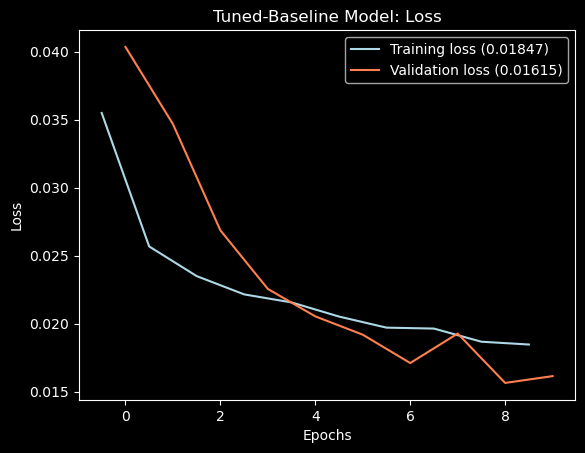

In [35]:
plot_loss(baseline_history)

## Hyperparameter tuning using Keras-Tuner

In [65]:
# function to build model for tuning
def build_model(hp):
    """
    Build model for hyperparamter tuning

    Params
    ------
    hp: HyperParameters class instance

    Returns
    -------
    Model: Keras model object
    """
    # Define number of classes for both outputs
    #num_angle_classes = 1024
    #num_speed_classes = 100

    # Define kernel_initializers for Dense layers
    glorot_init = tf.keras.initializers.GlorotNormal(seed=123)
    he_init = tf.keras.initializers.HeNormal(seed=123)

    # Define input
    input_shape = (224, 224, 3)

    # Define base model
    base = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

    # Define hyper-parameter tuning space
    # Choice of baseline model
    """baseline_choice = hp.Choice(name = 'baseline', values=['resnet50', 'mobilenet_v2', 'mobilenet_v3', 'vgg16'], ordered=False)
    if baseline_choice == 'resnet50':
        hp_baseline = resnet.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    elif baseline_choice == 'mobilenet_v2':
        hp_baseline = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    elif baseline_choice == 'mobilenet_v3':
        hp_baseline = mobilenet_v3.MobileNetV3(include_top=False, weights='imagenet', input_shape=input_shape)
    else:
        hp_baseline = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)"""
    # Tune dropout rate
    hp_dropout_rate = hp.Choice(name = 'dropout_rate', values=[1e-1, 2e-1, 3e-1, 4e-1, 5e-1])
    # Choose layers to freeze in base model
    hp_layers_to_train = hp.Int(name = 'layers_to_train', min_value=1, max_value=60, step=3)
    #hp_layers_to_train = hp.Int('layers_to_train', min_value=10, max_value=110, step=5)
    # Tune the kernel size in convolution layers
    #hp_kernel_size = hp.Choice(name='kernel_size', values=[3, 5])
    # Tune the number of strides in convolution layers
    #hp_strides = hp.Choice(name='strides', values=[1, 2])
    # Tune the number of units in the Dense layers
    hp_units1 = hp.Choice(name='dense1', values=[128, 256, 512, 1024], ordered=False)
    hp_units2 = hp.Choice(name='dense2', values=[64, 128, 256], ordered=False)
    #hp_units3 = hp.Choice(name='dense3', values=[16, 32, 64], ordered=False)
    #hp_units4 = hp.Choice(name='dense4', values=[8, 16, 32, 64, 128, 256, 512], ordered=False)
    #hp_l2 = hp.Choice(name = 'kernel_regularizer', values=[0.1, 0.01, 0.001])
    hp_activation = hp.Choice(name = 'activation', values=['relu', 'elu'], ordered=False)
    hp_output_activation = hp.Choice(name = 'output_activation', values=['linear', 'sigmoid', 'softplus'], ordered=False)
    # Tune momentum with RMSprop optimizer
    #hp_momentum = hp.Choice(name='momentum', values=[0.0, 0.1, 0.01, 0.99, 0.001, 0.0001])
    # Tune the learning rate for the optimizer
    # Choose an optimal value from different values of learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[2e-3, 4e-3, 6e-3, 2e-4, 6e-4])
    # Choose optimal weight decay
    hp_decay = hp.Choice(name='decay', values=[1e-1, 1e-2, 1e-3])
    # choose optimal optimizer
    optimizer_choice = hp.Choice('optimizer', ['Adam', 'Nadam', 'SGD', 'RMSprop'], ordered=False)
    if optimizer_choice == 'Adam':
        hp_optimizer = Adam(learning_rate=hp_learning_rate, decay=hp_decay)
    elif optimizer_choice == 'Nadam':
        hp_optimizer = Nadam(learning_rate=hp_learning_rate, decay=hp_decay)
    elif optimizer_choice == 'SGD':
            hp_optimizer = SGD(learning_rate=hp_learning_rate, decay=hp_decay)
    else:
        hp_optimizer = RMSprop(learning_rate=hp_learning_rate, decay=hp_decay)

    base.trainable = False # Freeze the model
    for layer in base.layers[-hp_layers_to_train:]:
        layer.trainable = True

    # Rebuild top
    model = Sequential(name='tuned_baseline_model')
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dropout(hp_dropout_rate))
    model.add(Dense(hp_units1, kernel_initializer=he_init))
    model.add(BatchNormalization())
    model.add(Activation(hp_activation))
    model.add(Dropout(hp_dropout_rate))
    model.add(Dense(hp_units2, kernel_initializer=he_init))
    model.add(BatchNormalization())
    model.add(Activation(hp_activation))
    model.add(Dense(2, activation=hp_output_activation, kernel_initializer=glorot_init))

    # Compile model
    model.compile(loss='mean_squared_error',
                  optimizer=hp_optimizer,
                  metrics=['mse', 'accuracy'])

    return model

In [67]:
tuning_dir = (
        'logs/tuned_scalars/' + 'tuned_baseline_model' + '_' + datetime.now().strftime('%Y%m%d-%H%M%S')
    ) # dir to save tuning logs

# Define tuner
tuner = kt.BayesianOptimization(hypermodel=build_model,
                    objective=kt.Objective('val_loss', direction='min'),
                    max_trials=3,
                    overwrite=True,
                    directory='./data/tuned_models/',
                    project_name='tuned_baseline_model'+ '_' + datetime.now().strftime('%Y%m%d-%H%M%S'))

In [68]:
backend.clear_session() # clear keras session before starting search

In [69]:
with tf.device(device_name='/device:GPU:0'):
    tuner.search(train_generator,
             epochs = 50,
             callbacks = [
                 EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001),
                 TensorBoard(log_dir=tuning_dir),
                 ModelCheckpoint('./data/tuned_models/tuned_baseline_model/best_weights.h5',save_best_only=True, monitor='val_loss'),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-9, patience=2, cooldown=5, min_delta=0.0001),
                 TerminateOnNaN()
             ],
             validation_data=val_generator,
             batch_size = BATCH_SIZE,
             steps_per_epoch = 150,
             validation_steps = 100
            )


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.2               |0.2               |dropout_rate
49                |49                |layers_to_train
256               |256               |dense1
64                |64                |dense2
relu              |relu              |activation
softplus          |softplus          |output_activation
0.006             |0.006             |learning_rate
0.001             |0.001             |decay
SGD               |SGD               |optimizer

Epoch 1/50


2023-04-25 02:53:26.025452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


150/150 [==============================] - ETA: 0s - loss: 0.2433 - mse: 0.2433 - accuracy: 0.5910

2023-04-25 02:55:16.635792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


150/150 [==============================] - 151s 994ms/step - loss: 0.2433 - mse: 0.2433 - accuracy: 0.5910 - val_loss: 0.1414 - val_mse: 0.1414 - val_accuracy: 0.7822 - lr: 0.0060
Epoch 2/50
150/150 [==============================] - 136s 904ms/step - loss: 0.1469 - mse: 0.1469 - accuracy: 0.6805 - lr: 0.0060
Epoch 3/50
150/150 [==============================] - 136s 910ms/step - loss: 0.1305 - mse: 0.1305 - accuracy: 0.7093 - lr: 0.0060
Epoch 4/50
150/150 [==============================] - 137s 912ms/step - loss: 0.1201 - mse: 0.1201 - accuracy: 0.7305 - lr: 0.0060
Epoch 5/50
150/150 [==============================] - 128s 851ms/step - loss: 0.1130 - mse: 0.1130 - accuracy: 0.7452 - lr: 0.0060
Epoch 6/50
150/150 [==============================] - 129s 858ms/step - loss: 0.1084 - mse: 0.1084 - accuracy: 0.7526 - lr: 0.0060
Epoch 7/50
150/150 [==============================] - 131s 870ms/step - loss: 0.1029 - mse: 0.1029 - accuracy: 0.7612 - lr: 0.0060
Epoch 8/50
150/150 [==============

KeyboardInterrupt: 

In [45]:
tuner.results_summary()

Results summary
Results in ./data/tuned_models/tuned_baseline_model
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 01 summary
Hyperparameters:
dropout_rate: 0.4
layers_to_train: 34
dense1: 256
dense2: 64
activation: relu
output_activation: sigmoid
learning_rate: 0.006
decay: 0.1
optimizer: Nadam
Score: 0.013392709195613861

Trial 3 summary
Hyperparameters:
dropout_rate: 0.2
layers_to_train: 19
dense1: 512
dense2: 128
activation: relu
output_activation: linear
learning_rate: 0.002
decay: 0.01
optimizer: RMSprop
Score: 0.01602204702794552

Trial 4 summary
Hyperparameters:
dropout_rate: 0.4
layers_to_train: 43
dense1: 512
dense2: 128
activation: relu
output_activation: softplus
learning_rate: 0.0006
decay: 0.01
optimizer: Nadam
Score: 0.01611521653831005

Trial 00 summary
Hyperparameters:
dropout_rate: 0.1
layers_to_train: 49
dense1: 1024
dense2: 128
activation: elu
output_activation: linear
learning_rate: 0.004
decay: 0.01
optimizer: RMSprop
Score: 0.0164051577

In [55]:
#best_params = tuner.get_best_hyperparameters()[0]

In [56]:
#best_model = tuner.get_best_models()[0]
#best_model.summary()

Model: "tuned_baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)     

In [66]:
#backend.clear_session() # clear keras session

In [67]:
#train_history = train(name='tuned_baseline_model', model=best_model, train_generator=train_generator, val_generator=val_generator, epochs=100, BATCH_SIZE=BATCH_SIZE,  step_size=step_size, val_step_size=val_step_size)

Epoch 1/100


2023-04-21 00:07:08.888706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


150/150 [==============================] - ETA: 0s - loss: 0.0185 - mse: 0.0185 - accuracy: 0.9594

2023-04-21 00:07:57.001911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


150/150 [==============================] - 73s 462ms/step - loss: 0.0185 - mse: 0.0185 - accuracy: 0.9594 - val_loss: 0.0124 - val_mse: 0.0124 - val_accuracy: 0.9733 - lr: 0.0060
Epoch 2/100
150/150 [==============================] - 74s 479ms/step - loss: 0.0182 - mse: 0.0182 - accuracy: 0.9621 - val_loss: 0.0132 - val_mse: 0.0132 - val_accuracy: 0.9729 - lr: 0.0060
Epoch 3/100
150/150 [==============================] - 81s 522ms/step - loss: 0.0184 - mse: 0.0184 - accuracy: 0.9595 - val_loss: 0.0129 - val_mse: 0.0129 - val_accuracy: 0.9735 - lr: 0.0060
Epoch 4/100
150/150 [==============================] - 79s 508ms/step - loss: 0.0170 - mse: 0.0170 - accuracy: 0.9640 - val_loss: 0.0135 - val_mse: 0.0135 - val_accuracy: 0.9722 - lr: 0.0060
Epoch 5/100
150/150 [==============================] - 74s 475ms/step - loss: 0.0174 - mse: 0.0174 - accuracy: 0.9622 - val_loss: 0.0129 - val_mse: 0.0129 - val_accuracy: 0.9749 - lr: 0.0060
Epoch 6/100
150/150 [==============================] - 76

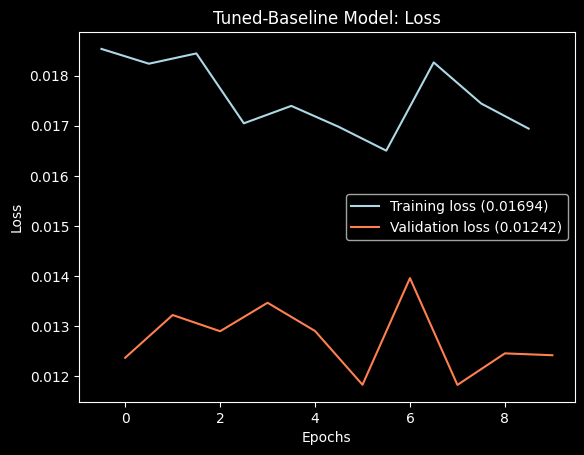

In [68]:
plot_loss(train_history)

## Hyperparameter tuning with GridSearchCV

In [35]:
# function to build estimator for grid search
def build_estimator(optimizer='adam', learning_rate=0.001, decay=0.1, dropout_rate=0.1, trainable_layers=10, dense1_nodes=1024, dense2_nodes=32, activation='relu', output_activation='linear'):
    """
    Build model for grid search

    Params
    ------

    Returns
    -------
    Model: Keras model object
    """

    # Define kernel_initializers for Dense layers
    glorot_init = tf.keras.initializers.GlorotNormal(seed=42)
    he_init = tf.keras.initializers.HeNormal(seed=42)

    # Define input
    input_shape = (224, 224, 3)

    # Define base model
    base = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

    base.trainable = False # Freeze the model
    for layer in base.layers[-trainable_layers:]:
        layer.trainable = True

    # Rebuild top
    model = Sequential(name='best_baseline_model')
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense1_nodes, kernel_initializer=he_init))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense2_nodes, kernel_initializer=he_init))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dense(2, activation=output_activation, kernel_initializer=glorot_init))

    # choice of optimizer
    optimizer=getattr(keras.optimizers, optimizer)(lr=learning_rate, decay=decay)

    # Compile model
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mse', 'accuracy'])

    return model

In [40]:
# Define grid search parameters
params = {
    'optimizer': ['adam', 'nadam', 'rmsprop'],
    'learning_rate': [1e-3, 4e-3, 6e-3, 2e-4, 5e-4],
    'decay': [0.1, 0.01, 0.001],
    'dropout_rate': [0.1, 0.2, 0.3],
    'trainable_layers': [15, 28, 35, 40, 45, 55, 60, 75],
    'dense1_nodes': [1024, 512, 256],
    'dense2_nodes': [128, 64, 32],
    'activation': ['relu', 'elu'],
    'output_activation': ['sigmoid', 'linear', 'softplus']
}

In [42]:
#from scikeras.wrappers import KerasRegressor
import scikeras as sk
from keras.wrappers.scikit_learn import KerasRegressor
import pickle

# create a scikeras wrapper model 
model = KerasRegressor(build_fn=build_estimator, verbose=0, epochs=50, batch_size=BATCH_SIZE)

/tmp/ipykernel_243/3592995416.py:7: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_estimator, verbose=0, epochs=50, batch_size=BATCH_SIZE)


In [43]:
# keras model serialization to use with scikeras

def serialize_model(model, path):
    with open(path, 'wb') as f:
        return pickle.dump(model, f)

def deserialize_model(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [44]:
serialize_model(model, 'model.pkl')
deserialized_model = deserialize_model('model.pkl')

In [45]:
# perform grid search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
grid = RandomizedSearchCV(estimator=model, param_distributions=params, n_jobs=-1, cv=2, verbose=1)

search_results = grid.fit(X=train_data['image_id'],
                          y=train_data[['angle', 'speed']],
                          epochs=50, 
                          steps_per_epoch=100)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


In [ ]:
def get_predictions(test_generator: Iterator, model: Sequential) -> pd.DataFrame:
    """
    Params
    ------
    test_generator: Iterator
        Data generator for testing
    model: Sequential model
        trained model to make

    Returns
    -------
    pd.DataFrame
        predictions as pandas dataframe
    """
    
    # extract image_id from test_generator
    image_ids = [filename.split('/')[1] for filename in test_generator.filenames]
    # convert to pandas dataframe with image_id as column name
    png_df = pd.DataFrame(data=image_ids, columns=['image_id'])
    png_df['image_id'] = png_df.image_id.apply(lambda x: os.path.split(x)[-1].split('.png')[0])

    # make predictions
    pred = model.predict(test_generator)

    # convert prediction numpy.ndarray( to pd.DataFrame
    pred_df = pd.concat([png_df, pd.DataFrame(data=pred, columns=['angle', 'speed'])], axis=1)
    # dropping index from dataframe
    pred_df.reset_index(drop=True)

    # return predictions
    return pred_df

In [ ]:
def save_csv(pred_df: pd.DataFrame) -> None:
    """
    Params
    ------
    pred_df: pd.DataFrame
        predictions in pandas dataframe

    Returns
    -------
    None
    """

    savedir='./submissions' # submissions directory
    if not os.path.exists(savedir):
        os.mkdir(savedir)

    csvfile = 'submission' + '_' + datetime.now().strftime('%d-%b_%I-%M%p') + '.csv' # csv file name
    savedir = str(os.path.join(savedir, csvfile))
    pred_df.to_csv(savedir, sep=',', index=False) # save to disk
    print('Saved CSV file on disk!')

In [ ]:
#test_path = os.path.join(data_path, 'test_data', 'images') # path to test data
#test_dir = os.path.join(data_path, 'test_data')
pred_df = get_predictions(test_generator, best_model)

In [ ]:
pred_df

In [ ]:
save_csv(pred_df)